# Classification using a Neural Network - Handle Class Imbalance (Keras)
The dataset is from https://www.kaggle.com/c/GiveMeSomeCredit <br>
"Banks play a crucial role in market economies. They decide who can get finance and on what terms and can make or break investment decisions. For markets and society to function, individuals and companies need access to credit. Credit scoring algorithms, which make a guess at the probability of default, are the method banks use to determine whether or not a loan should be granted."  <br>
We will build an MLP classifier to predict if someone will experience financial distress and therefore cannot pay off credit card (i.e. default). It is a binary classificaiton problem: default (class-1) or not default  (class-0) <br>
Real dataset is often imbalanced: class-i may have much more data samples than class-j.

In [176]:
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential 
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.datasets import mnist

import matplotlib.pyplot as plt
from IPython import display
import numpy as np
import pandas as pd

### Load the data

In [146]:
#every row of the table is a data sample (feature vector) from a person
from google.colab import files
uploaded = files.upload()
import io
df = pd.read_csv('cs_data.csv')
df.head()

Saving cs_data.csv to cs_data (3).csv


,id,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


#### handle nan (null) in data (i.e. missing values)
Some fields in the table are nan, which are missing values. <br>
For example, someone may not want to reveal monthly income to whoever made the table/survey, then the table got nan.

In [147]:
df.isnull().sum()

id                                          0
SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29731
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3924
dtype: int64

In [148]:
#here, we use a simple method:
#replace nan in each column with median value of that column
#there are other methods in pandas and sklearn: interpolation in pandas and KNNImputer in sklearn
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')
dfv=imputer.fit_transform(df.values)
df=pd.DataFrame(data=dfv, columns=df.columns)
df.isnull().sum()

id                                      0
SeriousDlqin2yrs                        0
RevolvingUtilizationOfUnsecuredLines    0
age                                     0
NumberOfTime30-59DaysPastDueNotWorse    0
DebtRatio                               0
MonthlyIncome                           0
NumberOfOpenCreditLinesAndLoans         0
NumberOfTimes90DaysLate                 0
NumberRealEstateLoansOrLines            0
NumberOfTime60-89DaysPastDueNotWorse    0
NumberOfDependents                      0
dtype: int64

### We have a highly imbalanced dataset
139974 data samples in class-0 (normal) <br>
10026 data samples in class-1 (financial distress)

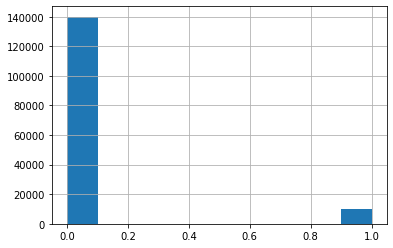

In [149]:
df['SeriousDlqin2yrs'].hist()

#### Classification Goal: predict 'SeriousDlqin2yrs' (Y) using the other features (X)

In [150]:
#'SeriousDlqin2yrs' is the target/class label, so it should not be in the input feature vector X
#'id' of a person is useless for the classification task
#so, we remove them from the table and get the input X
X=df.drop(['SeriousDlqin2yrs', 'id'], axis=1)
X.head()

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,0.766127,45.0,2.0,0.802982,9120.0,13.0,0.0,6.0,0.0,2.0
1,0.957151,40.0,0.0,0.121876,2600.0,4.0,0.0,0.0,0.0,1.0
2,0.658180,38.0,1.0,0.085113,3042.0,2.0,1.0,0.0,0.0,0.0
3,0.233810,30.0,0.0,0.036050,3300.0,5.0,0.0,0.0,0.0,0.0
4,0.907239,49.0,1.0,0.024926,63588.0,7.0,0.0,1.0,0.0,0.0


In [151]:
#Y is the target/class label
Y=df['SeriousDlqin2yrs']
Y.head()

0    1.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: SeriousDlqin2yrs, dtype: float64

In [152]:
# convert pandas dataframe/series to numpy array
# sklearn functions may not work well with pandas data types
X=X.values
Y=Y.values

In [153]:
#usually float32 is enough
X = X.astype('float32')
Y = Y.astype('float32')

### create training, validation and test sets

In [154]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
#split X_train and Y_train into a 'pure' training set and a validation set
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=0)
print('train:', X_train.shape, Y_train.shape)
print('validation:', X_val.shape, Y_val.shape)
print('test:', X_test.shape, Y_test.shape)

train: (108000, 10) (108000,)
validation: (12000, 10) (12000,)
test: (30000, 10) (30000,)


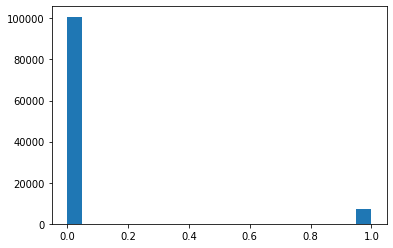

In [155]:
plt.hist(Y_train, bins=20);

Let's do upsampling for class-1

In [156]:
from sklearn.utils import resample
X_train_c1  = resample(X_train[Y_train==1], n_samples=100824)
Y_train_c1 = np.ones(X_train_c1.shape[0])
print('X_train_c1', X_train_c1.shape, Y_train_c1.shape)
X_train=np.concatenate([X_train[Y_train==0], X_train_c1], axis=0)
Y_train=np.concatenate([Y_train[Y_train==0], Y_train_c1], axis=0)
print('X_train.shape after upsampling', X_train.shape)
print('Y_train.shape after upsampling', Y_train.shape)

X_train_c1 (100824, 10) (100824,)
X_train.shape after upsampling (201648, 10)
Y_train.shape after upsampling (201648,)


In [157]:
Y.dtype

dtype('float32')

In [158]:
#apply feature normalization to training, validation and test sets
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
scaler.fit(X_train) # think about why fit to X_train, not X ?
X_train=scaler.transform(X_train)
X_val=scaler.transform(X_val)
X_test=scaler.transform(X_test)

### we need to use weighted classification accuracy

In [159]:
# we need to use weighted classification accuracy
# try to understand it
def weighted_accuracy(confusion):
    #input: confusion is the confusion matrix
    #output: acc is the weighted classification accuracy
    M=confusion.copy().astype('float32')
    for k in range(0, M.shape[0]):
        M[k]/=M[k].sum()+1e-8    
    acc = M.diagonal().sum()/M.sum()
    return acc

In [160]:
#we need this function to get weighted_accuracy on validation and test sets
def test_acc(model, X, Y):
    acc_test =0 
    num_classes=2
    confusion=np.zeros((num_classes,num_classes), dtype=np.int64)
    Yp=model.predict(X, batch_size=64)
    Y=Y.astype('int64')
    #0.5 is the threshold for classification
    Yp=(Yp.squeeze()>0.5).astype('int64')
    for i in range(0, num_classes):
        for j in range(0, num_classes):
            confusion[i,j]+=np.sum((Y==i)&(Yp==j)).astype('int64') 
    acc_test=weighted_accuracy(confusion)
    return acc_test, confusion

## Your task begins here <br>
see NN_binary_classification_Keras.ipynb in Lecture notes <br>
try Adam with lr=0.001 <br>
Usually, we need to tune the hyperparameters of a neural network, <br>
such as the number of layers, the number of units in each layer <br>
If you have plenty of time and enough computing power, try to find better hyperparameters <br>
read papers about "Neural Architecture Search" https://arxiv.org/abs/1808.05377

### Define the MLP model
https://github.com/keras-team/keras/issues/7678 <br>
we do not need to set the parameter "from_logits" for binary_crossentropy

In [166]:
model = Sequential()
model.add(Dense(units=256, activation='relu', input_shape=(10,)))
model.add(Dense(units=256, activation='relu'))
model.add(Dense(units=256, activation='relu'))
model.add(Dense(units=1,  activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer= keras.optimizers.Adam(learning_rate=0.0001),metrics=['accuracy'])   
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_56 (Dense)            (None, 256)               2816      
                                                                 
 dense_57 (Dense)            (None, 256)               65792     
                                                                 
 dense_58 (Dense)            (None, 256)               65792     
                                                                 
 dense_59 (Dense)            (None, 1)                 257       
                                                                 
Total params: 134,657
Trainable params: 134,657
Non-trainable params: 0
_________________________________________________________________


In [167]:
loss_train_list=[]
loss_val_list=[]
acc_train_list=[]
acc_val_list=[]

### Train the model
https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model

In [168]:
for epoch in range(0, 10):   
    print('epoch', epoch)
    #set epochs=1
    history=model.fit(X_train, Y_train, batch_size=64, epochs=1, validation_data=(X_val, Y_val))
    loss_train_list.extend(history.history['loss'])
    loss_val_list.extend(history.history['val_loss'])
    acc_train_list.extend(history.history['accuracy'])
    acc_val_list.extend(history.history['val_accuracy'])
    #save the model to a an HDF5 file
    model.save('H4P2T1_Keras_Sent_e'+str(epoch)+'.h5')

epoch 0
3151/3151 [==============================] - 20s 6ms/step - loss: 0.5513 - accuracy: 0.7216 - val_loss: 0.4120 - val_accuracy: 0.8683
epoch 1
3151/3151 [==============================] - 20s 6ms/step - loss: 0.5014 - accuracy: 0.7637 - val_loss: 0.4660 - val_accuracy: 0.8291
epoch 2
3151/3151 [==============================] - 20s 6ms/step - loss: 0.4980 - accuracy: 0.7661 - val_loss: 0.5091 - val_accuracy: 0.8012
epoch 3
3151/3151 [==============================] - 20s 6ms/step - loss: 0.4963 - accuracy: 0.7675 - val_loss: 0.5624 - val_accuracy: 0.7702
epoch 4
3151/3151 [==============================] - 20s 6ms/step - loss: 0.4958 - accuracy: 0.7673 - val_loss: 0.5382 - val_accuracy: 0.7759
epoch 5
3151/3151 [==============================] - 20s 6ms/step - loss: 0.4948 - accuracy: 0.7677 - val_loss: 0.4916 - val_accuracy: 0.7981
epoch 6
3151/3151 [==============================] - 19s 6ms/step - loss: 0.4941 - accuracy: 0.7682 - val_loss: 0.4606 - val_accuracy: 0.8108
epoch 

### Plot training histroy: loss vs epoch and accuracy vs epoch

In [169]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

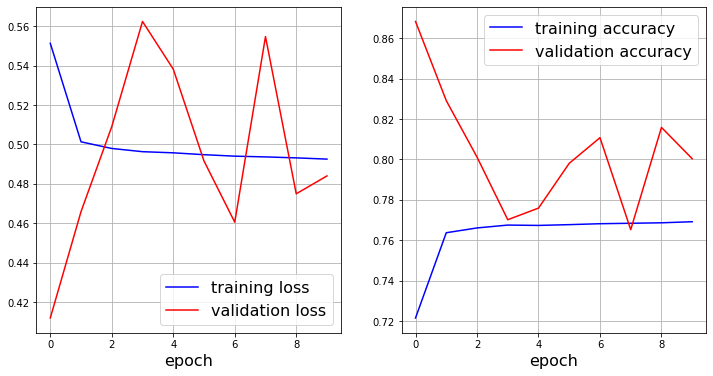

In [170]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))
ax[0].plot(np.arange(0,len(loss_train_list)), loss_train_list, '-b', label='training loss')
ax[0].plot(np.arange(0,len(loss_val_list)), loss_val_list, '-r', label='validation loss')
ax[0].set_xlabel('epoch',fontsize=16)
ax[0].legend(fontsize=16)
ax[0].grid(True)
ax[1].plot(np.arange(0,len(acc_train_list)), acc_train_list, '-b', label='training accuracy')
ax[1].plot(np.arange(0,len(acc_val_list)), acc_val_list, '-r', label='validation accuracy')
ax[1].set_xlabel('epoch',fontsize=16)
ax[1].legend(fontsize=16)
ax[1].grid(True)

### you may train the model for more than 10 epochs and see if you can get a better result

In [ ]:
#optional

### after training, we load the best model from the harddrive and evaluate the model on the test set
You may get a different result because of random initialization of network parameters

In [188]:
from tensorflow.keras.models import load_model
best_model = load_model('H4P2T1_Keras_Sent_e9.h5', custom_objects={'Sequential': Sequential})

In [189]:
# get accuracy from model.evaluate
score =best_model.evaluate(X_test, Y_test, batch_size=64, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.4841446280479431
Test accuracy: 0.8029333353042603


In [190]:
# make prediction on the test set
Y_test_pred=best_model.predict(X_test, batch_size=64)

In [ ]:
# weighted accuracy is the 'real' performance of the model


In [191]:
Yp_test=best_model.predict(X_test, batch_size=64)

In [192]:
Yp_test.shape

(30000, 1)

In [193]:
Yp_test

array([[0.22731197],
       [0.18129736],
       [0.23746729],
       ...,
       [0.1284723 ],
       [0.27799228],
       [0.10975006]], dtype=float32)